In [2]:
import numpy as np
import os, sys, time
import matplotlib.pyplot as plt
import numba
import scipy.optimize
import scipy.signal
from scipy.optimize import leastsq, curve_fit
from scipy.stats import pearsonr
from scipy.signal import hilbert
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def som_impedance_BS(f_vec, params):
    w_vec = 2*np.pi*f_vec
    alpha = np.sqrt((params['gm'] + np.sqrt(params['gm']**2 + \
                     w_vec**2*params['cm']**2))/(2*params['gi']))
    beta = np.sqrt((-params['gm'] + np.sqrt(params['gm']**2 + \
                    w_vec**2*params['cm']**2))/(2*params['gi']))
    z = alpha + 1j*beta  #z2 = -z (see notes page)
    z[w_vec<0] = alpha[w_vec<0] - 1j*beta[w_vec<0] #!!! in case of neg. freq.!! 
    # see https://en.wikipedia.org/wiki/Square_root#Algebraic_formula
    V1_BS_over_Is1 = 1/((params['Cs']*w_vec*1j + params['Gs']) + \
                        z*params['gi']*np.tanh(z*params['L']))
    V1_BS_over_Id1 = V1_BS_over_Is1 / np.cosh(z*params['L'])                    
    return V1_BS_over_Is1, V1_BS_over_Id1  
    
def make_V1_2C_Isd_normalized(args):
    def V1_2C_Isd_normalized(w_vec, *p):
        CsBS, GsBS, cm, gm, gi, L = args
        Cs, Gs, Cd = p
        Cs *= CsBS;  Gs *= GsBS;  Cd *= cm*L;
        lambd = np.sqrt(gi/gm);
        Gd = (GsBS + gi/lambd*np.tanh(L/lambd) - Gs) * np.cosh(L/lambd)
        Gj = (GsBS + gi/lambd*np.tanh(L/lambd) - Gs) / (1.0 - 1/np.cosh(L/lambd))
        V1_2C_over_Is1 = (Cd*w_vec*1j + Gd + Gj)/ \
                         ((Cs*w_vec*1j + Gs + Gj)*(Cd*w_vec*1j + Gd + Gj) - Gj**2)
        V1_2C_over_Id1 = Gj/((Cs*w_vec*1j + Gs + Gj)*(Cd*w_vec*1j + Gd + Gj) - Gj**2)
        return np.concatenate([np.real(V1_2C_over_Is1), np.imag(V1_2C_over_Is1), 
                               np.real(V1_2C_over_Id1), np.imag(V1_2C_over_Id1),
                               np.real(V1_2C_over_Id1-V1_2C_over_Is1),
                               np.imag(V1_2C_over_Id1-V1_2C_over_Is1)])
    return V1_2C_Isd_normalized

def Vs_traces_laplace(pBS,Vs_inf,Is0,Id0,Cs,Gs,Cd,Gd,Gj,Vr2C,DeltaVd,tgrid):
    # see INVLAP.m based on 
    # the method uses default values a=6, ns=20, nd=19
    # it is recommended to preserve a=6
    # increasing ns and nd leads to lower error
    a=6;  ns=20;  nd=19;
    if tgrid[0]==0:  
        tgrid = tgrid[1:]  # t=0 is not allowed
    alfa = 1j*np.zeros(ns+1+nd)
    beta = np.zeros(ns+1+nd)
    for n in range(len(alfa)): #prepare necessary coefficients
       alfa[n] = a + n*np.pi*1j
       beta[n] = -np.exp(a)*(-1)**(n+1);
    n = np.arange(1,nd+1)
    bdif = np.cumsum( scipy.special.gamma(nd+1)/scipy.special.gamma(nd+2-n)/
                      scipy.special.gamma(n) )/2**nd
    bdif = bdif[::-1]                  
    beta[ns+1:ns+1+nd] = beta[ns+1:ns+1+nd]*bdif
    beta[0] /= 2.0   
    dV = 0.002*pBS['L'];  Vgrid = np.arange(0,pBS['L']-dV/2,dV);
    VsBS = np.zeros_like(tgrid)
    Vs2C = np.zeros_like(tgrid)    
    for it in range(len(tgrid)):
        tp = tgrid[it]
        s_vals = alfa/tp  # complex frequencies s
        bt_vals = beta/tp
        btF = bt_vals*Vs_BS_laplace(s_vals,Vs_inf,Is0,Id0,pBS['Cs'],pBS['Gs'],
                                    pBS['cm'],pBS['gm'],pBS['gi'],pBS['lambd'],
                                    pBS['L'],Vgrid)   # Vshat(s)
        VsBS[it] = np.sum(np.real(btF))  #original Vs(t)
        btF = bt_vals*Vs_2C_laplace(s_vals,Vs_inf,Is0,Id0,Cs,Gs,
                                    Cd,Gd,Gj,Vr2C,DeltaVd)   # Vshat(s)
        Vs2C[it] = np.sum(np.real(btF))  #original Vs(t)
    return tgrid, VsBS, Vs2C

#@numba.njit    
def Vs_BS_laplace(s_vec,Vs_inf,Is0,Id0,Cs,Gs,cm,gm,gi,lambd,L,Vgrid):
    alpha = np.sqrt( (gm + cm*np.real(s_vec) + np.sqrt((gm + cm*np.real(s_vec))**2 + \
                     np.imag(s_vec)**2*cm**2))/(2*gi) )
    beta = np.sqrt( (-gm - cm*np.real(s_vec) + np.sqrt((gm + cm*np.real(s_vec))**2 + \
                     np.imag(s_vec)**2*cm**2))/(2*gi) )
    z_vec = alpha + 1j*beta
    dV = Vgrid[1]-Vgrid[0]
    Vr = Vgrid[0]
    if Is0>0 and Id0==0:
        integral = dV*np.sum(np.cosh(np.dot(L-np.array([Vgrid]).T,np.array([z_vec]))) * \
                             np.cosh((L-np.array([Vgrid]).T)/lambd), axis=0)
        integral_summand = cm*Vs_inf/np.cosh(L/lambd) * integral
    elif Is0==0 and Id0>0:
        integral = dV*np.sum(np.cosh(np.dot(L-np.array([Vgrid]).T,np.array([z_vec]))) * \
                             ( np.cosh(np.array([Vgrid]).T/lambd) + \
                              Gs*lambd/gi * np.sinh(np.array([Vgrid]).T/lambd) ), axis=0)        
        integral_summand = cm*Vs_inf * integral

    out = ( (Cs*Vr + Is0/s_vec) * np.cosh(z_vec*L) + integral_summand + Id0/s_vec ) / \
          ( (Cs*s_vec + Gs) * np.cosh(z_vec*L) + gi*z_vec*np.sinh(z_vec*L) )
    return out

#@numba.njit 
def Vs_2C_laplace(s_vec,Vs_inf,Is0,Id0,Cs,Gs,Cd,Gd,Gj,Vr2C,DeltaVd):
    Vd0 = (Gj*Vs_inf + Id0)/(Gd + Gj) + DeltaVd    
    out = ( (Is0/s_vec + Cs*Vr2C) * (Cd*s_vec + Gd + Gj) + Gj*(Cd*Vd0 + Id0/s_vec) ) / \
          ( (Cs*s_vec + Gs + Gj) * (Cd*s_vec + Gd + Gj) - Gj**2 )
    return out

def som_impedance_2C_Is(f_vec, params):
    w_vec = 2*np.pi*f_vec
    Cs = params['Cs'];  Gs = params['Gs'];  
    Cd = params['Cd']; Gd = params['Gd'];  Gj = params['Gj'];
    V1_2C_over_I1 = (Cd*w_vec*1j + Gd + Gj)/ \
                    ((Cs*w_vec*1j + Gs + Gj)*(Cd*w_vec*1j + Gd + Gj) - Gj**2)
    return V1_2C_over_I1
    
def som_impedance_2C_Id(f_vec, params):
    w_vec = 2*np.pi*f_vec
    Cs = params['Cs'];  Gs = params['Gs'];  
    Cd = params['Cd']; Gd = params['Gd'];  Gj = params['Gj'];
    V1_2C_over_I1 = Gj/((Cs*w_vec*1j + Gs + Gj)*(Cd*w_vec*1j + Gd + Gj) - Gj**2)
    return V1_2C_over_I1    
    
def fit_2C_params(freq_vals, pBS): 
    # somatic impedance of BS model
    V1_BS_over_Is1, V1_BS_over_Id1 = som_impedance_BS(freq_vals, pBS)
    w_vec = 2*np.pi*freq_vals
    args = (pBS['Cs'], pBS['Gs'], pBS['cm'], pBS['gm'], pBS['gi'], 
            pBS['L'], w_vec, V1_BS_over_Is1, V1_BS_over_Id1)
    p0 = np.array([1.0,1.0,1.0])
    args = (pBS['Cs'], pBS['Gs'], pBS['cm'], pBS['gm'], pBS['gi'], pBS['L'])
    ydata = np.concatenate([np.real(V1_BS_over_Is1), np.imag(V1_BS_over_Is1), 
                            np.real(V1_BS_over_Id1), np.imag(V1_BS_over_Id1),
                            np.real(V1_BS_over_Id1-V1_BS_over_Is1), 
                            np.imag(V1_BS_over_Id1-V1_BS_over_Is1)])                                                             
    popt, _ = scipy.optimize.curve_fit(make_V1_2C_Isd_normalized(args), w_vec, 
                                       ydata, p0=p0, bounds=(0.0, np.inf), 
                                       xtol=1e-9, ftol=1e-9, verbose=1)
                                      
    Cs, Gs, Cd = popt                                                        
    Cs *= pBS['Cs'];  Gs *= pBS['Gs'];  Cd *= pBS['cm']*pBS['L'];
    Gd = (pBS['Gs'] + pBS['gi']/pBS['lambd']*np.tanh(pBS['L']/pBS['lambd']) - Gs) * \
         np.cosh(pBS['L']/pBS['lambd'])
    Gj = (pBS['Gs'] + pBS['gi']/pBS['lambd']*np.tanh(pBS['L']/pBS['lambd']) - Gs) / \
         (1.0 - 1/np.cosh(pBS['L']/pBS['lambd'])) 
    # determine Vr_2C by fitting BS somatic V trace after reset (spike) 
    # for const. input Id0 that yields (threshold or) close-to-threshold V=V0
    # e.g. Vs_inf 1mV below VT, with dendritic depolarization according to Id0,
    # and determine Vr2C by least-sq. fitting that trace over, say, T=10*taum, with taum=Cs/(Gs+Gj);    
    # V-traces are (semi)analytically obtained using Laplace transform  
    Vs_inf = pBS['VT'] 
    Is0 = Vs_inf*(pBS['Gs'] + np.tanh(pBS['L']/pBS['lambd'])*pBS['gi']/pBS['lambd'])
    Id0 = Vs_inf*(np.cosh(pBS['L']/pBS['lambd'])*pBS['Gs'] + \
                  np.sinh(pBS['L']/pBS['lambd'])*pBS['gi']/pBS['lambd'])                          
    taus = Cs/(Gs+Gj)
    T = 1*taus  #10*pBS['Cs']/(pBS['Gs']+Gj)
    tgrid = np.linspace(0.001,T,10)  # 0 will be excluded by the inverse Laplace method
    Vr2C_vals = np.arange(-0.001,0.006,0.0001)  # use larger range for general purpose
#    DeltaVd_vals = np.arange(-0.005,0.005,0.00025)
    DeltaVd_vals = np.array([0.0])
    errors = np.zeros((len(Vr2C_vals),len(DeltaVd_vals)))
    for i in range(len(Vr2C_vals)):
        for j in range(len(DeltaVd_vals)):
            Vr2C = Vr2C_vals[i];  DeltaVd = DeltaVd_vals[j]; 
            # Is0 from above, Id0 = 0:
            times, VsBS, Vs2C = Vs_traces_laplace(pBS,Vs_inf,Is0,0.0,Cs,Gs,Cd,Gd,Gj,Vr2C,DeltaVd,tgrid)
            error1 = np.sum(np.abs(Vs2C-VsBS))
            # Is0 = 0, Id0 from above:
            times, VsBS, Vs2C = Vs_traces_laplace(pBS,Vs_inf,0.0,Id0,Cs,Gs,Cd,Gd,Gj,Vr2C,DeltaVd,tgrid)
            error2 = np.sum(np.abs(Vs2C-VsBS))            
            errors[i,j] = error1 + error2
    i,j = np.unravel_index(errors.argmin(),errors.shape)    
    Vr2C = Vr2C_vals[i]
    DeltaVd = DeltaVd_vals[j]
    tgrid = np.linspace(0,T,200)  # for plotting; 0 will be excluded by the inverse Laplace method
    t1, VsBS_Is, Vs2C_Is = Vs_traces_laplace(pBS,Vs_inf,Is0,0.0,Cs,Gs,Cd,Gd,Gj,Vr2C,DeltaVd,tgrid)
    t2, VsBS_Id, Vs2C_Id = Vs_traces_laplace(pBS,Vs_inf,0.0,Id0,Cs,Gs,Cd,Gd,Gj,Vr2C,DeltaVd,tgrid)
    params2C = {}       
    params2C['Cs'] = Cs    
    params2C['Gs'] = Gs 
    params2C['Cd'] = Cd
    params2C['Gd'] = Gd
    params2C['Gj'] = Gj
    params2C['Vr'] = Vr2C 
    params2C['DeltaV'] = DeltaVd  # this should be 0
    params2C['VT'] = pBS['VT']    
    params2C['Gexp'] = Cs*pBS['Gs']/pBS['Cs']                         
    params2C['DeltaT'] = pBS['DeltaT']
    params2C['Vth'] = pBS['Vth'] 
    params2C['Delta'] = pBS['gi']/params2C['Gj']  #(m)
    V1_2C_over_Is1 = som_impedance_2C_Is(freq_vals, params2C)
    V1_2C_over_Id1 = som_impedance_2C_Id(freq_vals, params2C)
    # somatic voltage response to field (BS model)
    V1_BS_over_E1 = pBS['gi'] * (V1_BS_over_Id1-V1_BS_over_Is1)
    V1_2C_over_E1 = params2C['Gj']*params2C['Delta']*(V1_2C_over_Id1 - V1_2C_over_Is1)
    fitcurves = {}
    fitcurves['freq_vals'] = freq_vals
    fitcurves['Zhat_Is_BS'] = V1_BS_over_Is1
    fitcurves['Zhat_Id_BS'] = V1_BS_over_Id1
    fitcurves['Zhat_Is_2C'] = V1_2C_over_Is1
    fitcurves['Zhat_Id_2C'] = V1_2C_over_Id1
    fitcurves['Vshat_over_E1_BS'] = V1_BS_over_E1
    fitcurves['Vshat_over_E1_2C'] = V1_2C_over_E1
    fitcurves['postspike_time_vals'] = tgrid
    fitcurves['Vs_postspike_Is_BS'] = np.concatenate(([pBS['Vr']], VsBS_Is))
    fitcurves['Vs_postspike_Id_BS'] = np.concatenate(([pBS['Vr']], VsBS_Id))
    fitcurves['Vs_postspike_Is_2C'] = np.concatenate(([params2C['Vr']], Vs2C_Is))
    fitcurves['Vs_postspike_Id_2C'] = np.concatenate(([params2C['Vr']], Vs2C_Id))
    return params2C, fitcurves

In [4]:
paramsBS = {}
# BALL AND STICK NEURON MODEL params (SEALED END, LUMPED SOMA)
paramsBS['c_spec'] = 1.0e-2  # specific membrane capacitance (F/m2)
paramsBS['g_spec'] = 1/3.0  # specific membrane (leak) conductance (S/m2)
paramsBS['gi_spec'] = 1/2.0  # specific internal (axial) conductance (S/m)
paramsBS['L'] = 7e-4 #def.: 7e-4 [4e-4, 10e-4] cable length (m)
paramsBS['M'] = 0  #0 or 3e-4 or >L for full reset #TODO: remove
                    # distance from soma at which dendritic hyperpolarization becomes 
                    # negligible (if <L) --> no reset beyond this point (m)
paramsBS['d_dend'] = 1.0e-6 #def.: 1.0e-6 [0.5e-6, 1.5e-6] cable diameter (m) 
paramsBS['d_soma'] = 15e-6 #def.: 15e-6 [10e-6, 20e-6] soma diameter (m) 
# for (dendritic) cable:
paramsBS['cm'] = paramsBS['c_spec'] * (paramsBS['d_dend'] * np.pi)  # (F/m)
paramsBS['gm'] = paramsBS['g_spec'] * (paramsBS['d_dend'] * np.pi)  # (S/m)
paramsBS['gi'] = paramsBS['gi_spec'] * (paramsBS['d_dend']**2/4 * np.pi)  # (S*m)
paramsBS['lambd'] = np.sqrt(paramsBS['gi']/paramsBS['gm'])
# for (lumped) soma:
paramsBS['Cs'] = paramsBS['c_spec'] * (paramsBS['d_soma']**2 * np.pi)  # (F)
paramsBS['Gs'] = paramsBS['g_spec'] * (paramsBS['d_soma']**2 * np.pi)  # (S)
paramsBS['Vr'] = 0.0  # (V) 
paramsBS['VT'] = 10e-3  # (V)

paramsBS['DeltaT'] = 0.0015  # (V)
paramsBS['Vth'] = 0.02  # (V) the cutoff voltage
freq_vals = np.arange(0,1e4,0.5)  # (Hz) 
params2C, fitcurves = fit_2C_params(freq_vals, paramsBS)  

Cs, Cd, Gs, Gd, Gi = params2C['Cs'], params2C['Cd'], params2C['Gs'], params2C['Gd'], params2C['Gj']
Gexp, DeltaT, VT   = params2C['Gexp'], params2C['DeltaT'], params2C['VT']
Vr, Vth            = params2C['Vr'], params2C['Vth']
Delta, DeltaV      = params2C['Delta'], params2C['DeltaV']
params2C = np.array([Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth])

`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.6765e+18, final cost 3.8726e+17, first-order optimality 4.86e+12.


In [5]:
def powerfit(x, ain1, bin1, cin1):
        return ain1*x**bin1 + cin1
    
@numba.njit
def generateOUNoise_Liu(tvar): 
    tau_OU = 5 # 5ms
    OUNoise = np.zeros_like(tvar)
    dt1 = tvar[1] - tvar[0] # ms
    for i in range(len(OUNoise)-1):
        OUNoise[i+1] = OUNoise[i] - (OUNoise[i]/tau_OU)*dt1 + np.sqrt(dt1)*np.sqrt(2/tau_OU)*np.random.randn()   
    return OUNoise
    
def calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=19.0):
    '''峰值时刻作为放电时刻'''
    risingBefore = np.hstack((0, vsoma[1:] - vsoma[:-1])) > 0  # v(t)-v(t-1)>0
    fallingAfter = np.hstack((vsoma[1:] - vsoma[:-1], 0)) < 0  # v(t)-v(t+1)<0
    localMaximum = np.logical_and(fallingAfter, risingBefore) # 逻辑与，上述两者逻辑与为真代表为局部最大值，是放电峰值可能存在的时刻
    largerThanThresh = vsoma > Vth  # 定义一个远大于放电阈值的电压值
    binarySpikeVector = np.logical_and(localMaximum,largerThanThresh) # 放电峰值时刻二进制序列
    spikeInds = np.nonzero(binarySpikeVector)
    spikeNumber = np.sum(binarySpikeVector)
    outputSpikeTimes = tvar[spikeInds]
    firingRate = 1e3 * spikeNumber / (tvar[-1] - tvar[0])
    return spikeNumber, firingRate, spikeInds, outputSpikeTimes

def calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0):
    dt = tvar[1] - tvar[0]
    nDtPer1ms = int(1/dt)
    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence1 = np.sum(spikeCountSequence, axis=1)

    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence2 = np.sum(spikeCountSequence, axis=1)
    
    outputCorrelation   = pearsonr(spikeCountSequence1, spikeCountSequence2)[0]
    return outputCorrelation

def calcTacsSpikePLV(vsoma, Evar, tvar, Vth=19.0):
    '''采用希尔伯特变换, 0°对应了电场波形的峰值, 90°对应了电场下降边缘'''
    analyticSignal = hilbert(Evar)
    tacsInstantaneousPhase = np.angle(analyticSignal)  # 计算结果为弧度值,-π~π
    _, _, spikeIndex, spikeTime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=Vth)
    spikePhaseRadian = tacsInstantaneousPhase[spikeIndex]
    spikePhaseRadian[spikePhaseRadian < 0 ] += 2*np.pi
    pluralPLV = np.mean(np.exp(1j*spikePhaseRadian))
    spikePhaseDegree = np.rad2deg(spikePhaseRadian)
    fieldSpikePLV = np.abs(pluralPLV)
    
    return fieldSpikePLV, spikePhaseDegree, pluralPLV

In [6]:
'''
Paper: Weak electric fields promote resonance in neuronal spiking activity: Analytical results from two-compartment cell and network models
'''
@numba.njit
def twoCompModel(params2C, vs, vd, Is=0.0, Id=0.0, E=0.0, dt=0.1):
    # Cs, Cd, Gs, Gd, Gi = params2C['Cs'], params2C['Cd'], params2C['Gs'], params2C['Gd'], params2C['Gj']
    # Gexp, DeltaT, VT   = params2C['Gexp'], params2C['DeltaT'], params2C['VT']
    # # Vr, Vth            = params2C['Vr'], params2C['Vth']
    # Delta, DeltaV      = params2C['Delta'], params2C['DeltaV']
    Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV = params2C
    vsn = vs + dt * ( Gi*(vd-vs-Delta*E) - Gs*vs + Is + Gexp*DeltaT*np.exp((vs-VT)/DeltaT)) / Cs
    vdn = vd + dt * (-Gi*(vd-vs-Delta*E) - Gd*vd + Id) / Cd
    return vsn, vdn
    
@numba.njit
def runModel(params2C=np.ones(1), dt=0.01, tvar=0., Is=0.0, Id=0.0, Evar=0.0):
    Vr, Vth  = params2C[-2], params2C[-1]
    vs, vd   = 0, 0
    vsoma, vdend = np.zeros_like(tvar), np.zeros_like(tvar)
    for i, t in enumerate(tvar):
        vs, vd = twoCompModel(params2C[0:-2], vs, vd, Is=Is[i], Id=Id[i], E=Evar[i], dt=dt)
        if vs > Vth:
            vs = Vr
        vsoma[i], vdend[i] = vs, vd
        
    return vsoma, vdend

# 复现传输阻抗Ztrans: (Figure 1C)

In [77]:
%%time
dt       = 0.01/1e3
duration = 100
tvar     = np.arange(0, duration, dt)
Is   = 1e-12*scipy.signal.chirp(tvar, f0=1, t1=duration, f1=1000)
Id   = np.zeros_like(tvar)
Evar = np.zeros_like(tvar)
# Is = 5e-12 + 20.0*1e-12 * np.random.randn(len(tvar))
# Id = 5e-12 + 20.0*1e-12 * np.random.randn(len(tvar))
vsoma1, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
Is2   = np.zeros_like(tvar) 
Id2   = 1e-12*scipy.signal.chirp(tvar, f0=1, t1=duration, f1=1000)
vsoma2, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is2, Id=Id2, Evar=Evar)

Wall time: 1.48 s


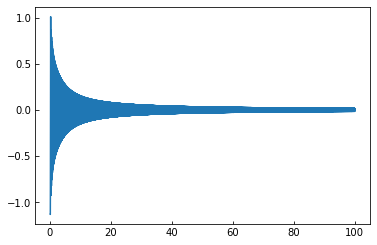

In [79]:
idx = int(0.25/dt)
plt.plot(tvar[idx:], vsoma1[idx:]*1e3)
# plt.xlim(0, 0.5)

In [80]:
frelist, powerin  = FFT(Is, dt)
frelist, powerout = FFT(vsoma1, dt)
Ztrans = powerout/powerin
temp = np.abs(frelist - 1)
index_1 = temp.tolist().index(np.min(temp))
temp = np.abs(frelist - 1000)
index_100 = temp.tolist().index(np.min(temp))
tempfre = frelist[index_1:index_100]
tempZtrans = Ztrans[index_1:index_100]

frelist, powerin  = FFT(Id2, dt)
frelist, powerout = FFT(vsoma2, dt)
Ztrans = powerout/powerin
temp = np.abs(frelist - 1)
index_1 = temp.tolist().index(np.min(temp))
temp = np.abs(frelist - 1000)
index_100 = temp.tolist().index(np.min(temp))
tempfre2 = frelist[index_1:index_100]
tempZtrans2 = Ztrans[index_1:index_100]

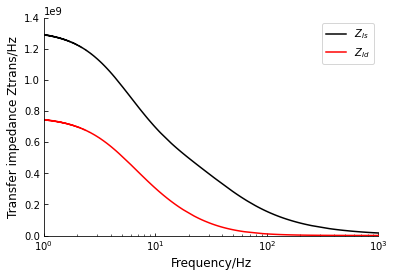

In [81]:
plt.figure(figsize=(6, 4))
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.semilogx(tempfre, tempZtrans, label=r'$Z_{Is}$', color='k')
plt.semilogx(tempfre2, tempZtrans2, label=r'$Z_{Id}$', color='r')
plt.legend()
plt.xlim(1e0, 1e3)
plt.ylim(0, 1.4e9)
plt.xlabel('Frequency/Hz', fontsize=12)
plt.ylabel('Transfer impedance Ztrans/Hz', fontsize=12)
ax = plt.gca() # ax = plt.axes()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

In [84]:
%%time
dt       = 0.01/1e3
duration = 10
tvar     = np.arange(0, duration, dt)
Evar     = np.zeros_like(tvar)
Is       = 5e-12 + 40e-12 * np.random.randn(len(tvar))
Id       = 5e-12 + 40e-12 * np.random.randn(len(tvar))
vsoma, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)

Wall time: 96.7 ms


(0.0, 1.0)

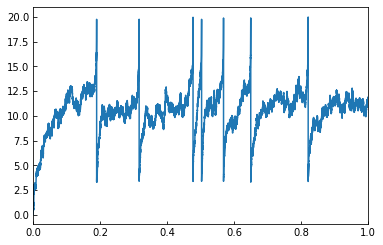

In [85]:
plt.plot(tvar, vsoma*1e3)
plt.xlim(0, 1)

# 交流电场作用下的极化响应: Figure 2B

In [86]:
%%time
dt       = 0.01/1e3
duration = 100
tvar     = np.arange(0, duration, dt)
Is   = np.zeros_like(tvar)
Id   = np.zeros_like(tvar)
Evar = 1*scipy.signal.chirp(tvar, f0=1, t1=duration, f1=1000)
vsoma, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)

frelist, powerin  = FFT(Evar, dt)
frelist, powerout = FFT(vsoma, dt)
Ztrans = powerout/powerin
temp = np.abs(frelist - 1)
index_1 = temp.tolist().index(np.min(temp))
temp = np.abs(frelist - 1000)
index_100 = temp.tolist().index(np.min(temp))
tempfre = frelist[index_1:index_100]
tempZtrans = Ztrans[index_1:index_100]

Wall time: 517 ms


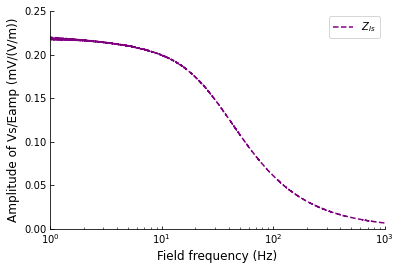

In [92]:
plt.figure(figsize=(6, 4))
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.semilogx(tempfre, tempZtrans*1e3, label=r'$Z_{Is}$', color='purple', ls='--')
plt.legend()
plt.xlim(1e0, 1e3)
plt.ylim(0, 0.25)
plt.xlabel('Field frequency (Hz)', fontsize=12)
plt.ylabel('Amplitude of Vs/Eamp (mV/(V/m))', fontsize=12)
ax = plt.gca() # ax = plt.axes()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

In [199]:
%%time
dt       = 0.01/1e3
duration = 1
tvar     = np.arange(0, duration, dt)
Is   = np.zeros_like(tvar)
Id   = np.zeros_like(tvar)
Evar = 50*np.sin(2*np.pi*10*tvar)
vsoma, vdend = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)

Wall time: 4.11 ms


Text(0, 0.5, 'Polarization response (mV)')

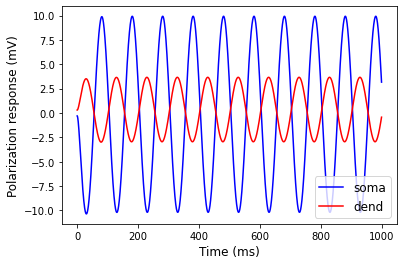

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(tvar*1e3, vsoma*1e3-0.3, color='b', label='soma')
ax.plot(tvar*1e3, vdend*1e3+0.3, color='r', label='dend')
ax.legend(fontsize=12)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Polarization response (mV)', fontsize=12)

# 交流电场如何调节放电序列相关性

## 确定放电频率范围：仅有树突扰动输入

In [193]:
%%time
dt       = 0.01/1e3                     # second
duration = 50                           # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 0, 5, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3
spikeNumber, firingRate, spikeInds, outputSpikeTimes = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=19.0)
outputCorrelation = calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0)
firingRate, outputCorrelation

Wall time: 1.04 s


(35.42000708400141, 0.18507076709811143)

Text(0, 0.5, 'Somatic voltage (mV)')

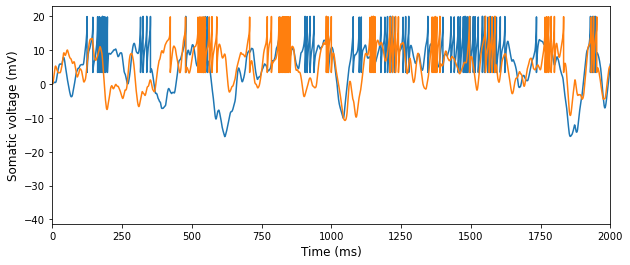

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(tvar, vsoma1)
ax.plot(tvar, vsoma2)
# ax.scatter(outputSpikeTimes, [-10]*len(outputSpikeTimes))
ax.set_xlim(0, 2000)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Somatic voltage (mV)', fontsize=12)

[ 0.29859562 34.93043395  0.1767504 ]


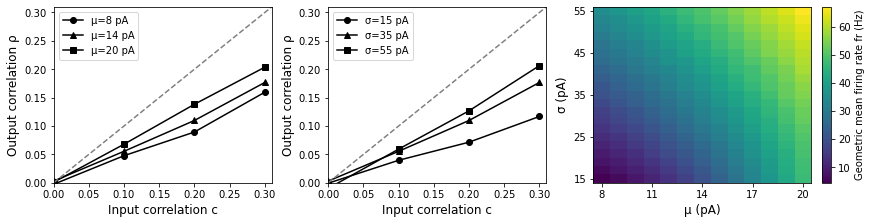

In [34]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
print(np.mean(res, axis=0)[3, 6, 11])
fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
'''ρ-c with different μ (σ = 35 pA)'''
mu_index = [0, 6, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[0].plot(list_c, data_rou[mu_index[i]][11], color='k', marker=marker[i], label='μ=%.f pA' % list_mu[mu_index[i]])
ax[0].legend(fontsize=10)
ax[0].plot([0, 0.31], [0, 0.31], ls='--', color='grey')
ax[0].set_xlabel('Input correlation c', fontsize = 12)
ax[0].set_ylabel('Output correlation ρ', fontsize = 12)
ax[0].set_xlim(0, 0.31)
ax[0].set_ylim(0, 0.31)

'''ρ-c with different σ (μ = 14 pA)'''
sigma_index = [0, 11, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[1].plot(list_c, data_rou[6][sigma_index[i]], color='k', marker=marker[i], label='σ=%.f pA' % list_sigma[sigma_index[i]])
ax[1].legend(fontsize=10) 
ax[1].plot([0, 0.31], [0, 0.31], ls='--', color='grey')
ax[1].set_xlabel('Input correlation c', fontsize = 12)
ax[1].set_ylabel('Output correlation ρ', fontsize = 12)
ax[1].set_xlim(0, 0.31)
ax[1].set_ylim(0, 0.31)

'''μ-σ-fr with c=0.3'''
yfr  = np.mean(res, axis=0).transpose(3, 0, 2, 1)[1][-1] # shape=(mu, sigma)
ipm  = ax[2].pcolormesh(list_mu, list_sigma, yfr, shading='auto')
cbar = plt.colorbar(ipm, ax=ax[2], label='Geometric mean firing rate fr (Hz)', )
ax[2].set_xlabel('μ (pA)', fontsize = 12)
ax[2].set_ylabel('σ (pA)', fontsize = 12)
ax[2].set_xticks(np.arange(8, 20+1, 3))
ax[2].set_yticks(np.arange(15, 55+1, 10))

Text(0.5, 1.0, 'Without  Efield')

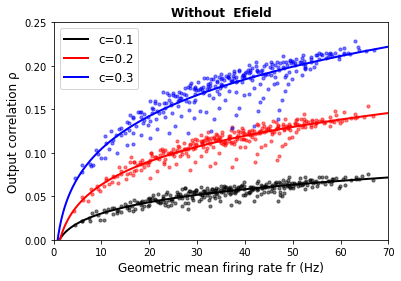

In [11]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
list_x, list_y, list_xfit, list_yfit  = [], [], [], []
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    '''拟合'''
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)

colors=['k', 'r', 'b']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(3):
    ax.scatter(list_x[i], list_y[i], color=colors[i], s=10, alpha=0.5)
    ax.plot(list_xfit[i], list_yfit[i], color=colors[i], lw=2, label='c=%.1f' % list_c[i+1])
ax.legend(fontsize=12)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation ρ', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0., 0.25)
ax.set_title('Without  Efield', fontsize=12, weight='bold')


Text(0.5, 1.0, 'Without  Efield')

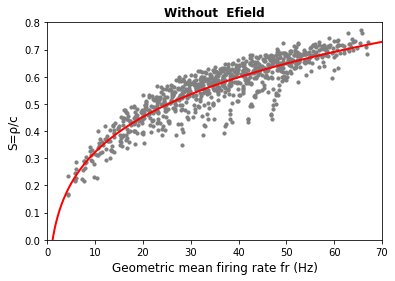

In [27]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
list_x, list_y = np.array([]), np.array([])
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou   = data_rou / list_c[i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    list_x = np.hstack((list_x, data_fr))
    list_y = np.hstack((list_y, data_rou))

'''拟合'''
xtemp       = sorted(enumerate(list_x), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(list_x))
y           = np.array(multi_piker(list_y))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit        = powerfit(xfit, *best_vals)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x, y, color='grey', s=10)
ax.plot(xfit, yfit, color='r', lw=2)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('S=ρ/c', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0., 0.8)
ax.set_title('Without  Efield', fontsize=12, weight='bold')

Text(0.5, 1.0, 'Without  Efield')

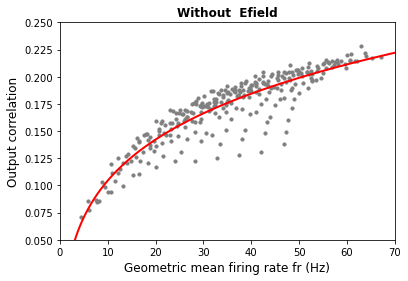

In [32]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][-1] # shape=(mu, sigma), cin=0.3
data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][-1] # shape=(mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
'''拟合'''
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_noEF   = powerfit(xfit, *best_vals)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x, y, color='grey', s=10)
ax.plot(xfit, yfit_noEF, color='r', lw=2)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0.05, 0.25)
ax.set_title('Without  Efield', fontsize=12, weight='bold')

Text(0.5, 1.0, 'Without  Efield')

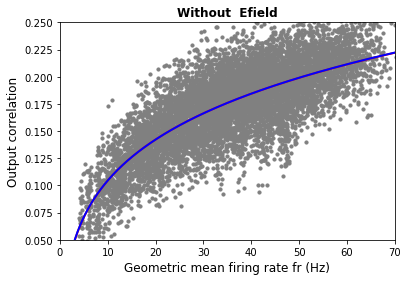

In [156]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = res.transpose(4, 1, 0, 2, 3)[2][-1] # shape=(times, mu, sigma), cin=0.3
data_fr    = res.transpose(4, 1, 0, 2, 3)[1][-1] # shape=(times, mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
'''拟合'''
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_noEFAll= powerfit(xfit, *best_vals)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x, y, color='grey', s=10)
ax.plot(xfit, yfit_noEF, color='r', lw=2)
ax.plot(xfit, yfit_noEFAll, color='b', lw=2)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0.05, 0.25)
ax.set_title('Without  Efield', fontsize=12, weight='bold')

(34.93, 0.1949143182863765)

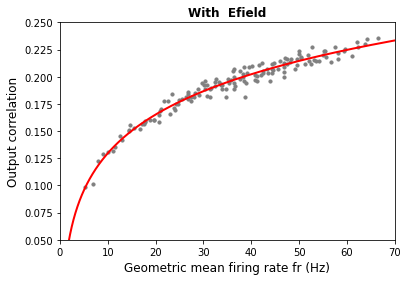

In [37]:
list_c     = [0.3]
list_mu = np.arange(8, 20+0.1, 1)
list_sigma = np.arange(15, 55+1, 4)
res        = np.load('data/times20_c03_mu8-20pA_sigma15-55pA_AE10_fE10.npy')
res        = res.squeeze()  # shape=(times, mu, sigma, results)
data_rou   = np.mean(res, axis=0).transpose(2, 0, 1)[2] # shape=(mu, sigma), cin=0.3
data_fr    = np.mean(res, axis=0).transpose(2, 0, 1)[1] # shape=(mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
'''拟合'''
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_EF     = powerfit(xfit, *best_vals)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x, y, color='grey', s=10)
ax.plot(xfit, yfit_EF, color='r', lw=2)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0.05, 0.25)
ax.set_title('With  Efield', fontsize=12, weight='bold')
xfit[3493], yfit_EF[3493]

Text(0.5, 1.0, 'With  Efield (10V/m, 10Hz)')

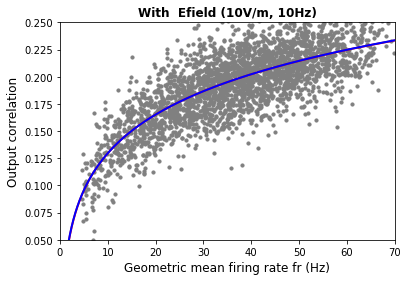

In [162]:
list_c     = [0.3]
list_mu = np.arange(8, 20+0.1, 1)
list_sigma = np.arange(15, 55+1, 4)
res        = np.load('data/times20_c03_mu8-20pA_sigma15-55pA_AE10_fE10.npy')
res        = res.squeeze()  # shape=(times, mu, sigma, results)
data_rou   = res.transpose(3, 0, 1, 2)[2] # shape=(times, mu, sigma), cin=0.3
data_fr    = res.transpose(3, 0, 1, 2)[1] # shape=(times, mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
'''拟合'''
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_EFAll  = powerfit(xfit, *best_vals)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x, y, color='grey', s=10)
ax.plot(xfit, yfit_EF, color='r', lw=2)
ax.plot(xfit, yfit_EFAll, color='b', lw=2)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0.05, 0.25)
ax.set_title('With  Efield (10V/m, 10Hz)', fontsize=12, weight='bold')

Text(0.5, 1.0, 'With  Efield (10V/m, 10Hz)')

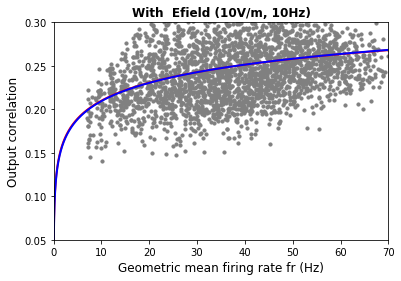

In [174]:
list_c     = [0.3]
list_mu = np.arange(8, 20+0.1, 1)
list_sigma = np.arange(15, 55+1, 4)
res        = np.load('data/times20_c03_mu8-20pA_sigma15-55pA_AE20_fE10.npy')
res        = res.squeeze()  # shape=(times, mu, sigma, results)
data_rou   = res.transpose(3, 0, 1, 2)[2] # shape=(times, mu, sigma), cin=0.3
data_fr    = res.transpose(3, 0, 1, 2)[1] # shape=(times, mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
'''拟合'''
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_EFAll_20V10Hz  = powerfit(xfit, *best_vals)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x, y, color='grey', s=10)
ax.plot(xfit, yfit_EFAll_20V10Hz, color='b', lw=2)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0.05, 0.3)
ax.set_title('With  Efield (20V/m, 10Hz)', fontsize=12, weight='bold')

Text(0.5, 1.0, 'With  Efield (10V/m, 30Hz)')

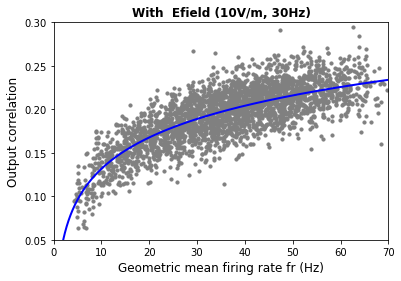

In [185]:
list_c     = [0.3]
list_mu = np.arange(8, 20+0.1, 1)
list_sigma = np.arange(15, 55+1, 4)
res        = np.load('data/times20_c03_mu8-20pA_sigma15-55pA_AE10_fE30.npy')
res        = res.squeeze()  # shape=(times, mu, sigma, results)
data_rou   = res.transpose(3, 0, 1, 2)[2] # shape=(times, mu, sigma), cin=0.3
data_fr    = res.transpose(3, 0, 1, 2)[1] # shape=(times, mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
'''拟合'''
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_EFAll_10V30Hz  = powerfit(xfit, *best_vals)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x, y, color='grey', s=10)
ax.plot(xfit, yfit_EFAll_10V30Hz, color='b', lw=2)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation', fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0.05, 0.3)
ax.set_title('With  Efield (10V/m, 30Hz)', fontsize=12, weight='bold')

Text(0, 0.5, 'Output correlation')

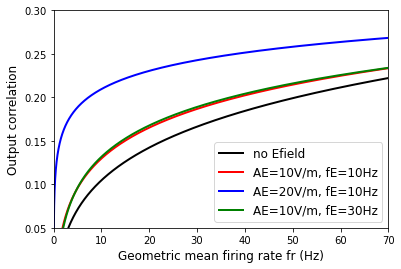

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(xfit, yfit_noEFAll, color='k', lw=2, label='no Efield')
ax.plot(xfit, yfit_EFAll, color='r', lw=2, label='AE=10V/m, fE=10Hz')
ax.plot(xfit, yfit_EFAll_20V10Hz, color='b', lw=2, label='AE=20V/m, fE=10Hz')
ax.plot(xfit, yfit_EFAll_10V30Hz, color='g', lw=2, label='AE=10V/m, fE=30Hz')
ax.legend(fontsize=12)
ax.set_xlim(0, 70)
ax.set_ylim(0.05, 0.3)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation', fontsize=12)

## 现象：交流电场能否调节相关性

In [28]:
%%time
'''no EF'''
dt       = 0.01/1e3                     # second
duration = 40                           # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 0, 10, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma10, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma20, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma10, vsoma20 = tvar*1e3, vsoma10*1e3, vsoma20*1e3
outputCorrelation0 = calcSpikeTrainCorrelation(vsoma10, vsoma20, tvar, Tin=10, Vth=19.0)

'''AE=10, fE=10'''
dt       = 0.01/1e3                     # second
duration = 40                           # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 10, 10, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma11, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma21, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma11, vsoma21 = tvar*1e3, vsoma11*1e3, vsoma21*1e3
outputCorrelation1 = calcSpikeTrainCorrelation(vsoma11, vsoma21, tvar, Tin=10, Vth=19.0)

'''AE=20, fE=10'''
dt       = 0.01/1e3                     # second
duration = 40                           # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 20, 10, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma12, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma22, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma12, vsoma22 = tvar*1e3, vsoma12*1e3, vsoma22*1e3
outputCorrelation2 = calcSpikeTrainCorrelation(vsoma12, vsoma22, tvar, Tin=10, Vth=19.0)

'''AE=10, fE=30'''
dt       = 0.01/1e3                     # second
duration = 40                           # second
tvar     = np.arange(0, duration, dt)   # second
AE, fE, phiE   = 10, 30, 0
c, mud, sigmad = 0.3, 14, 35             # pA
Is   = np.zeros_like(tvar)              # A
Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
vsoma13, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
vsoma23, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
tvar, vsoma13, vsoma23 = tvar*1e3, vsoma13*1e3, vsoma23*1e3
outputCorrelation3 = calcSpikeTrainCorrelation(vsoma13, vsoma23, tvar, Tin=10, Vth=19.0)

Wall time: 3.03 s


In [29]:
outputCorrelation0, outputCorrelation1, outputCorrelation2, outputCorrelation3

(0.17653633999414042,
 0.21320032938059236,
 0.249140919450078,
 0.2217564573129971)

In [23]:
listPLV, listPhase, listBinCenter, listHist = [], [], [], []
bins = np.arange(0, 361, 10)
'''no EF'''
Evar = np.sin(2 * np.pi * 10 * tvar/1e3)
plv, phase, pluralPlv = calcTacsSpikePLV(vsoma10, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

plv, phase, pluralPlv = calcTacsSpikePLV(vsoma20, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

'''10V/m, 10Hz'''
Evar = 10*np.sin(2 * np.pi * 10 * tvar/1e3)
plv, phase, pluralPlv = calcTacsSpikePLV(vsoma11, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

plv, phase, pluralPlv = calcTacsSpikePLV(vsoma21, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

'''20V/m, 10Hz'''
Evar = 20*np.sin(2 * np.pi * 10 * tvar/1e3)
plv, phase, pluralPlv = calcTacsSpikePLV(vsoma12, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

plv, phase, pluralPlv = calcTacsSpikePLV(vsoma22, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

'''10V/m, 30Hz'''
Evar = 10*np.sin(2 * np.pi * 30 * tvar/1e3)
plv, phase, pluralPlv = calcTacsSpikePLV(vsoma13, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

plv, phase, pluralPlv = calcTacsSpikePLV(vsoma23, Evar, tvar, Vth=19.0)
preferPhase = (np.angle(pluralPlv)*180/np.pi + 360) % 360
hist, bin_edge = np.histogram(phase, bins=bins)
bin_center = bin_edge[:-1] + (bins[1]-bins[0])/2
listPLV.append(plv), listPhase.append(preferPhase), listBinCenter.append(bin_center), listHist.append(hist)

(None, None, None, None)

<BarContainer object of 36 artists>

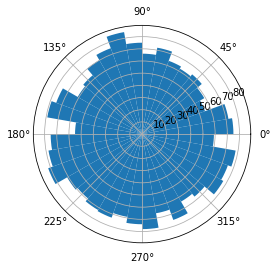

In [269]:
bins = np.arange(0, 361, 10)
hist, bin_edge = np.histogram(phase10, bins=bins)
bin_center = bin_edge[:-1] + 5
fig= plt.figure(figsize=(4, 4))
ax0 = fig.add_subplot(111, projection='polar')
ax0.bar(np.radians(bin_center), hist, width=np.radians(10), bottom=0.0)

<BarContainer object of 36 artists>

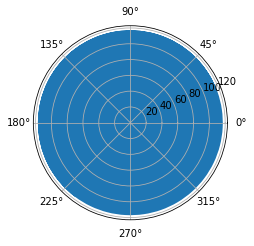

In [256]:
theta = np.radians(np.arange(5, 360, 10))

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(241, projection='polar')
ax.bar(bin_center, hist, width=10, bottom=0.0)

In [220]:
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = res.transpose(4, 1, 0, 2, 3)[2][-1] # shape=(times, mu, sigma), cin=0.3
data_fr    = res.transpose(4, 1, 0, 2, 3)[1][-1] # shape=(times, mu, sigma), cin=0.3
data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
'''拟合'''
xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(data_fr))
y           = np.array(multi_piker(data_rou))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit_noEFAll= powerfit(xfit, *best_vals)

In [7]:
list_AE = np.arange(0, 50+1, 5)
list_fE = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE0-50_fE5-100.npy')
data    = res.squeeze().mean(axis=0).transpose(2, 0, 1)
data.shape

(5, 11, 11)

Text(0.5, 0.98, 'output correlation ρ')

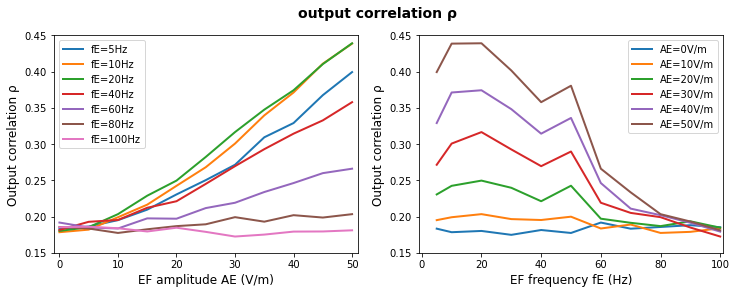

In [8]:
indexfE = [0, 1, 2, 4, 6, 8, 10]
indexAE = [0, 2, 4, 6, 8, 10]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for idx in indexfE:
    ax[0].plot(list_AE, data[2, :, idx], lw=2, label='fE=%dHz' % list_fE[idx])
for idx in indexAE:
    ax[1].plot(list_fE, data[2, idx, :], lw=2, label='AE=%dV/m' % list_AE[idx])
for item in ax:
    item.legend(fontsize=10)
ax[0].set_xlim(0-1, 50+1)
ax[0].set_ylim(0.15, 0.45)
ax[0].set_xlabel('EF amplitude AE (V/m)', fontsize=12)
ax[0].set_ylabel('Output correlation ρ', fontsize=12)

ax[1].set_xlim(0-1, 100+1)
ax[1].set_ylim(0.15, 0.45)
ax[1].set_xlabel('EF frequency fE (Hz)', fontsize=12)
ax[1].set_ylabel('Output correlation ρ', fontsize=12)
fig.suptitle('output correlation ρ', fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'Mean firing rate fr')

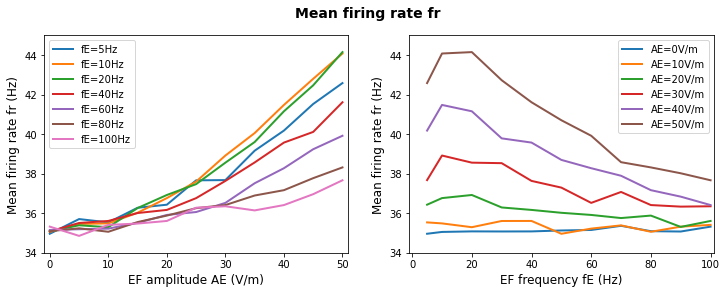

In [9]:
indexfE = [0, 1, 2, 4, 6, 8, 10]
indexAE = [0, 2, 4, 6, 8, 10]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for idx in indexfE:
    ax[0].plot(list_AE, data[1, :, idx], lw=2, label='fE=%dHz' % list_fE[idx])
for idx in indexAE:
    ax[1].plot(list_fE, data[1, idx, :], lw=2, label='AE=%dV/m' % list_AE[idx])
for item in ax:
    item.legend(fontsize=10)
ax[0].set_xlim(0-1, 50+1)
ax[0].set_ylim(34, 45)
ax[0].set_xlabel('EF amplitude AE (V/m)', fontsize=12)
ax[0].set_ylabel('Mean firing rate fr (Hz)', fontsize=12)

ax[1].set_xlim(0-1, 100+1)
ax[1].set_ylim(34, 45)
ax[1].set_xlabel('EF frequency fE (Hz)', fontsize=12)
ax[1].set_ylabel('Mean firing rate fr (Hz)', fontsize=12)
fig.suptitle('Mean firing rate fr', fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'Field-spike entrainment PLV')

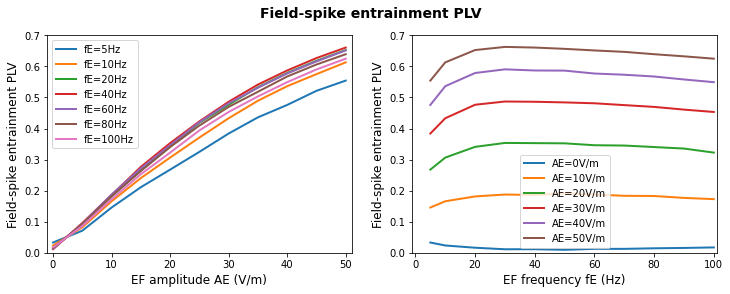

In [10]:
indexfE = [0, 1, 2, 4, 6, 8, 10]
indexAE = [0, 2, 4, 6, 8, 10]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for idx in indexfE:
    ax[0].plot(list_AE, data[3, :, idx], lw=2, label='fE=%dHz' % list_fE[idx])
for idx in indexAE:
    ax[1].plot(list_fE, data[3, idx, :], lw=2, label='AE=%dV/m' % list_AE[idx])
for item in ax:
    item.legend(fontsize=10)
    item.set_ylim(0, 0.7)
ax[0].set_xlim(0-1, 50+1)
ax[0].set_xlabel('EF amplitude AE (V/m)', fontsize=12)
ax[0].set_ylabel('Field-spike entrainment PLV', fontsize=12)

ax[1].set_xlim(0-1, 100+1)
ax[1].set_xlabel('EF frequency fE (Hz)', fontsize=12)
ax[1].set_ylabel('Field-spike entrainment PLV', fontsize=12)
fig.suptitle('Field-spike entrainment PLV', fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'Varying Efield amplitude')

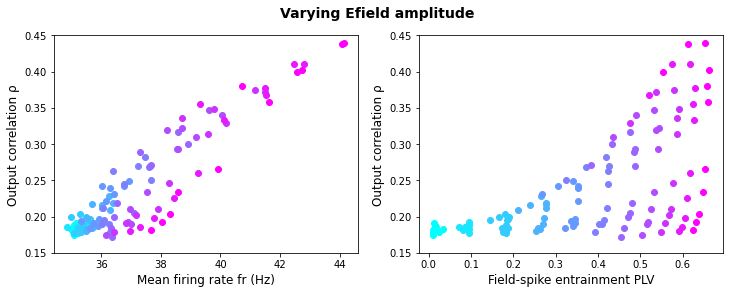

In [11]:
colorLength = 11
list_color0 = plt.cm.get_cmap('cool', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in range(11):
    data1 = data[:, i, :]
    data_fr, data_rou, data_plv = data1[1], data1[2], data1[3]
    data_fr, data_rou, data_plv  = data_fr.flatten(), data_rou.flatten(), data_plv.flatten()
    ax[0].scatter(data_fr, data_rou, color=colors[i])
    ax[1].scatter(data_plv, data_rou, color=colors[i])
ax[0].set_xlabel('Mean firing rate fr (Hz)', fontsize=12)
ax[0].set_ylabel('Output correlation ρ', fontsize=12)
ax[1].set_xlabel('Field-spike entrainment PLV', fontsize=12)
ax[1].set_ylabel('Output correlation ρ', fontsize=12)
for item in ax:
    item.set_ylim(0.15, 0.45)
fig.suptitle('Varying Efield amplitude', fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'Varying Efield frequency')

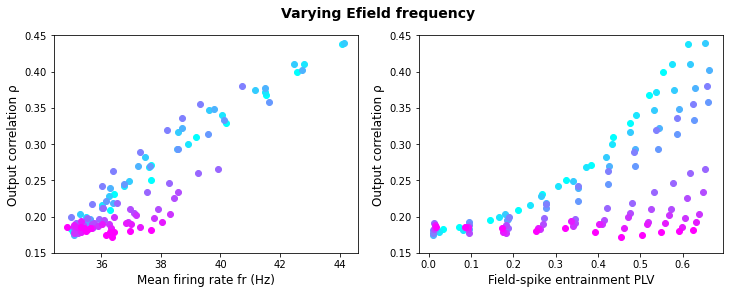

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in range(11):
    data1 = data[:, :, i]
    data_fr, data_rou, data_plv = data1[1], data1[2], data1[3]
    data_fr, data_rou, data_plv  = data_fr.flatten(), data_rou.flatten(), data_plv.flatten()
    ax[0].scatter(data_fr, data_rou, color=colors[i])
    ax[1].scatter(data_plv, data_rou, color=colors[i])
ax[0].set_xlabel('Mean firing rate fr (Hz)', fontsize=12)
ax[0].set_ylabel('Output correlation ρ', fontsize=12)
ax[1].set_xlabel('Field-spike entrainment PLV', fontsize=12)
ax[1].set_ylabel('Output correlation ρ', fontsize=12)
for item in ax:
    item.set_ylim(0.15, 0.45)
fig.suptitle('Varying Efield frequency', fontsize=14, fontweight='bold')

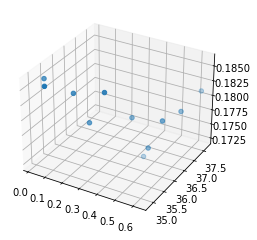

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_plv, data_fr, data_rou)
ax.mouse_init()

Text(0, 0.5, 'Frequency of Efield (Hz)')

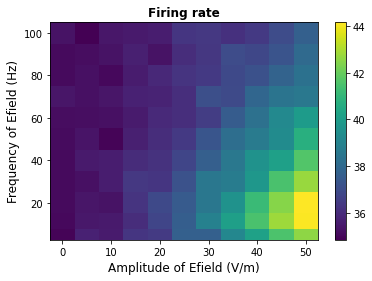

In [47]:
plt.title('Firing rate', fontsize=12, weight='bold')
plt.pcolormesh(list_AE, list_fE, data[1].transpose())
plt.colorbar()
plt.xlabel('Amplitude of Efield (V/m)', fontsize=12)
plt.ylabel('Frequency of Efield (Hz)', fontsize=12)

Text(0, 0.5, 'Frequency of Efield (Hz)')

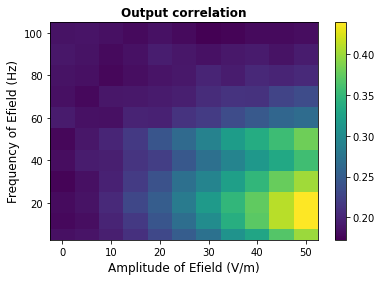

In [48]:
plt.title('Output correlation', fontsize=12, weight='bold')
plt.pcolormesh(list_AE, list_fE, data[2].transpose())
plt.colorbar()
plt.xlabel('Amplitude of Efield (V/m)', fontsize=12)
plt.ylabel('Frequency of Efield (Hz)', fontsize=12)

Text(0, 0.5, 'Frequency of Efield (Hz)')

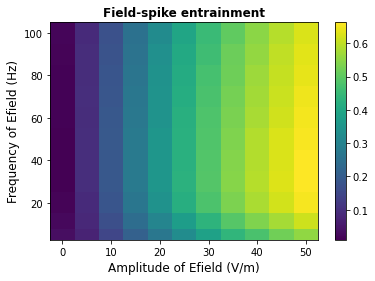

In [49]:
plt.title('Field-spike entrainment', fontsize=12, weight='bold')
plt.pcolormesh(list_AE, list_fE, data[3].transpose())
plt.colorbar()
plt.xlabel('Amplitude of Efield (V/m)', fontsize=12)
plt.ylabel('Frequency of Efield (Hz)', fontsize=12)

## 电场作用下60个神经元放电时刻图

In [94]:
%%time
neuronNumber = 60
spikeTimeList = []
for i in range(neuronNumber):
    dt       = 0.01/1e3                     # second
    duration = 20                          # second
    tvar     = np.arange(0, duration, dt)   # second
    AE, fE, phiE   = 40, 10, 0
    c, mud, sigmad = 0.3, 14, 35             # pA
    Is   = np.zeros_like(tvar)              # A
    Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
    Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
    Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
    vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
    vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
    tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3
    _, _, _, spiketime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=19.0)
    spikeTimeList.append(spiketime)
    _, _, _, spiketime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=19.0)
    spikeTimeList.append(spiketime)

Wall time: 21.6 s


(0.0, 2000.0)

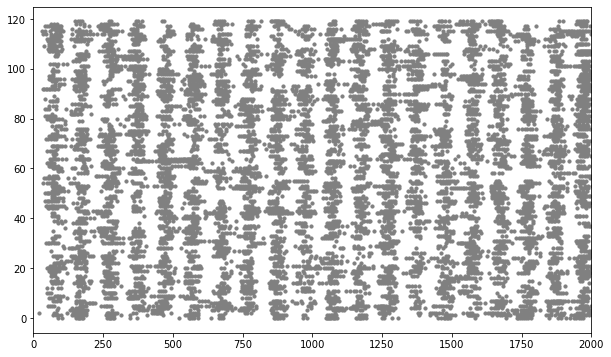

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(len(spikeTimeList)):
    ax.scatter(spikeTimeList[i], [i]*len(spikeTimeList[i]), color='grey', s=10)
ax.set_xlim(0, 2000)

In [111]:
%%time
listrou, listfr = [], []
for i in range(30):
    dt       = 0.01/1e3                     # second
    duration = 20                          # second
    tvar     = np.arange(0, duration, dt)   # second
    AE, fE, phiE   = 1, 10, 0
    c, mud, sigmad = 0.3, 14, 35             # pA
    Is   = np.zeros_like(tvar)              # A
    Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
    Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
    Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
    vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
    vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
    tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3
    _, fr1, _, _ = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=19.0)
    _, fr2, _, _ = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=19.0)
    ans_fr = np.sqrt(fr1 * fr2)
    ans_rou = calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0)
    listrou.append(ans_rou)
    listfr.append(ans_fr)
rou = np.array(listrou).mean()
fr  = np.array(listfr).mean()
fr, rou

Wall time: 12 s


(35.255773412041066, 0.1816122519873401)

In [112]:
%%time
listrou, listfr = [], []
for i in range(30):
    dt       = 0.01/1e3                     # second
    duration = 20                          # second
    tvar     = np.arange(0, duration, dt)   # second
    AE, fE, phiE   = 20, 10, 0
    c, mud, sigmad = 0.3, 14, 35             # pA
    Is   = np.zeros_like(tvar)              # A
    Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
    Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
    Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
    vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
    vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
    tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3
    _, fr1, _, _ = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=19.0)
    _, fr2, _, _ = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=19.0)
    ans_fr = np.sqrt(fr1 * fr2)
    ans_rou = calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0)
    listrou.append(ans_rou)
    listfr.append(ans_fr)
rou = np.array(listrou).mean()
fr  = np.array(listfr).mean()
fr, rou

Wall time: 12 s


(36.58796842417787, 0.25335435781695453)

In [113]:
%%time
listrou, listfr = [], []
for i in range(30):
    dt       = 0.01/1e3                     # second
    duration = 20                          # second
    tvar     = np.arange(0, duration, dt)   # second
    AE, fE, phiE   = 40, 10, 0
    c, mud, sigmad = 0.3, 14, 35             # pA
    Is   = np.zeros_like(tvar)              # A
    Idc  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(c) + mud       # pA
    Id1  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id2  = generateOUNoise_Liu(tvar*1e3) * sigmad * np.sqrt(1 - c) + Idc   # pA
    Id1, Id2 = Id1*1e-12, Id2*1e-12         # A
    Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) # V/m
    vsoma1, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id1, Evar=Evar)
    vsoma2, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id2, Evar=Evar)
    tvar, vsoma1, vsoma2 = tvar*1e3, vsoma1*1e3, vsoma2*1e3
    _, fr1, _, _ = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=19.0)
    _, fr2, _, _ = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=19.0)
    ans_fr = np.sqrt(fr1 * fr2)
    ans_rou = calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0)
    listrou.append(ans_rou)
    listfr.append(ans_fr)
rou = np.array(listrou).mean()
fr  = np.array(listfr).mean()
fr, rou

Wall time: 12.2 s


(41.089239646910194, 0.3691079025485045)

# 交流电场如何改变ρ-fr关系

In [205]:
list_mu    = np.arange(8, 20 + 0.1, 2)
list_sigma = np.arange(15, 55 + 1, 5)
list_AE    = np.arange(2.5, 20+1, 2.5)
list_fE    = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
res        = np.load('data/times10_c03_mu8-20pA_sigma15-55pA_AE0-20_fE5-100.npy')
res        = res.squeeze()  # shape=(times, mu, sigma, AE, fE, results)
data = res.transpose(5, 3, 4, 0, 1, 2)  # shape = (results, AE, fE, times, mu, sigma)

Text(0.5, 1.0, 'Field-spike entrainment PLV')

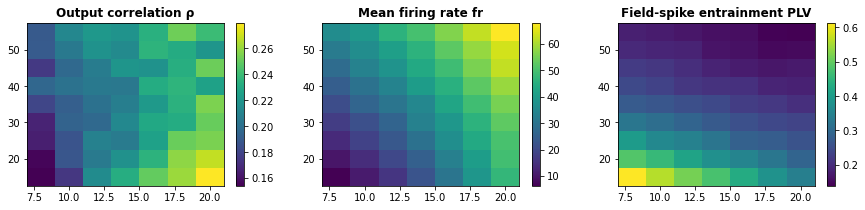

In [212]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
idxAE, idxfE = 5, 1
ipm = ax[0].pcolormesh(list_mu, list_sigma, data[2][idxAE][idxfE].mean(axis=0).transpose())
plt.colorbar(ipm, ax=ax[0])
ipm = ax[1].pcolormesh(list_mu, list_sigma, data[1][idxAE][idxfE].mean(axis=0).transpose())
plt.colorbar(ipm, ax=ax[1])
ipm = ax[2].pcolormesh(list_mu, list_sigma, data[3][idxAE][idxfE].mean(axis=0).transpose())
plt.colorbar(ipm, ax=ax[2])
ax[0].set_title('Output correlation ρ', fontsize=12, weight='bold')
ax[1].set_title('Mean firing rate fr', fontsize=12, weight='bold')
ax[2].set_title('Field-spike entrainment PLV', fontsize=12, weight='bold')

Text(0.5, 0.98, 'ρ-fr relation changes with AE (10Hz)')

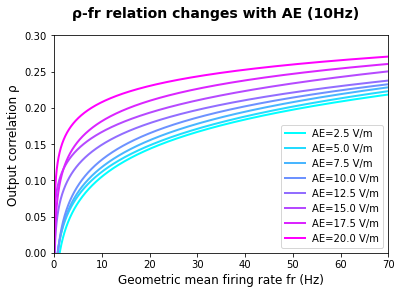

In [196]:
data_AE = data[:, :, 1, :, :, :] # 10Hz shape= (results, AE, times, mu, sigma) = (5, 8, 10, 7, 9)
list_x, list_y, list_xfit, list_yfit = [], [], [], []
for i in range(len(list_AE)):
    data_rou, data_fr = data_AE[2][i], data_AE[1][i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)

colorLength = len(list_x)
list_color0 = plt.cm.get_cmap('cool', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(colorLength):
    ax.plot(list_xfit[i], list_yfit[i], color=colors[i], lw=2, label='AE=%.1f V/m' % list_AE[i])
ax.legend(fontsize=10)
ax.set_ylim(0, 0.3)
ax.set_xlim(-0.1, 70)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation ρ', fontsize=12)
fig.suptitle('ρ-fr relation changes with AE (10Hz)', fontsize=14, fontweight='bold')

Text(0.5, 0.98, 'ρ-fr relation changes with Af (10V/m)')

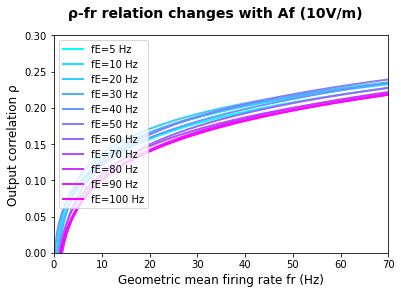

In [200]:
data_fE = data[:, 3, :, :, :, :] # 10V/m shape= (results, Af, times, mu, sigma) = (5, 8, 10, 7, 9)
list_x, list_y, list_xfit, list_yfit = [], [], [], []
for i in range(len(list_fE)):
    data_rou, data_fr = data_fE[2][i], data_fE[1][i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)

colorLength = len(list_x)
list_color0 = plt.cm.get_cmap('cool', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(colorLength):
    ax.plot(list_xfit[i], list_yfit[i], color=colors[i], lw=2, label='fE=%d Hz' % list_fE[i])
ax.legend(fontsize=10)
ax.set_ylim(0, 0.3)
ax.set_xlim(-0.1, 70)
ax.set_xlabel('Geometric mean firing rate fr (Hz)', fontsize=12)
ax.set_ylabel('Output correlation ρ', fontsize=12)
fig.suptitle('ρ-fr relation changes with Af (10V/m)', fontsize=14, fontweight='bold')

# Figure 3: 现象：引入交流电场是够改变输出相关性

In [217]:
list_AE = [0, 5, 10]
list_fE = [10, 20]
res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE0-10-20_fE10-20-50.npy')
res     = res.squeeze()  # shape=(times, AE, fE, results)
data_rou= res.transpose(3, 1, 2, 0)[2]  #shape=(AE, fE, times)
data_fr = res.transpose(3, 1, 2, 0)[1] 
data_plv= res.transpose(3, 1, 2, 0)[3] 
data_rou.shape

(3, 3, 30)

Text(0, 0.5, 'Output correlation ρ')

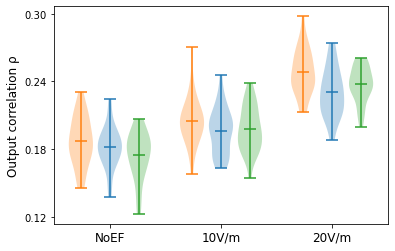

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
positions = np.array([0, 1, 2])*2.3
ax.violinplot(data_rou[:, 0, :].transpose(), positions=positions, showmeans=True)
ax.violinplot(data_rou[:, 1, :].transpose(), positions=positions-0.6, showmeans=True)
ax.violinplot(data_rou[:, 2, :].transpose(), positions=positions+0.6, showmeans=True)
ax.set_xticks(positions, labels=['NoEF', '10V/m', '20V/m'], fontsize=12)
ax.set_yticks(np.arange(0.12, 0.31, 0.06))
ax.set_ylabel('Output correlation ρ', fontsize=12)

Text(0, 0.5, 'Mean firing rate fr (Hz)')

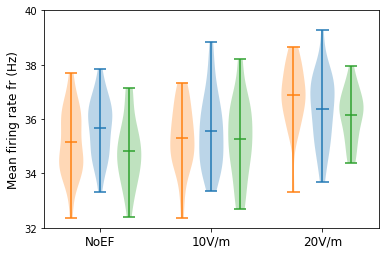

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
positions = np.array([0, 1, 2])*2.3
ax.violinplot(data_fr[:, 0, :].transpose(), positions=positions, showmeans=True)
ax.violinplot(data_fr[:, 1, :].transpose(), positions=positions-0.6, showmeans=True)
ax.violinplot(data_fr[:, 2, :].transpose(), positions=positions+0.6, showmeans=True)
ax.set_xticks(positions, labels=['NoEF', '10V/m', '20V/m'], fontsize=12)
ax.set_yticks(np.arange(32, 41, 2))
ax.set_ylabel('Mean firing rate fr (Hz)', fontsize=12)